Raw set
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


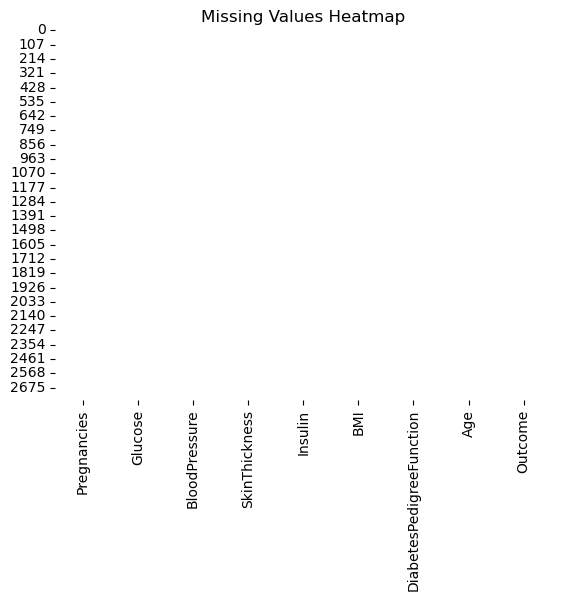

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns 

#Pre processing the Dataset
# Loading the raw dataset
df = pd.read_csv("../../data/raw/FC212039_Healthcare-Diabetes.csv").drop(columns=["Id"])

#checking for duplicates

df.loc[df.duplicated(keep='first')]

print("Raw set")
print(df.head())
sns.heatmap(df.isnull(), cbar=False, cmap='Grays')
plt.title("Missing Values Heatmap")
plt.show()



Training set
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.822718  0.244675      -0.207593      -1.638738 -0.477253 -0.941669   
1    -0.521754 -0.986463      -0.863452      -0.125256 -0.615125 -0.148965   
2    -0.220790  1.670204      -1.191382      -0.730649  0.399220  0.031828   
3     0.983067 -0.273698       0.284302      -1.235143 -0.428013 -1.233717   
4     1.885959 -0.370894      -0.207593      -0.226155 -0.623004 -0.719155   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.003363 -0.944742        0  
1                 -1.044663 -0.774592        0  
2                  0.374156  0.246309        1  
3                 -0.015023 -0.179066        0  
4                 -1.010954  0.586610        1  
test set
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.521754 -0.565284      -1.191382       1.085529 -0.585581  0.309969   
1    -0.822718 -0.176503      -1.027417      -0.629750 -0.4

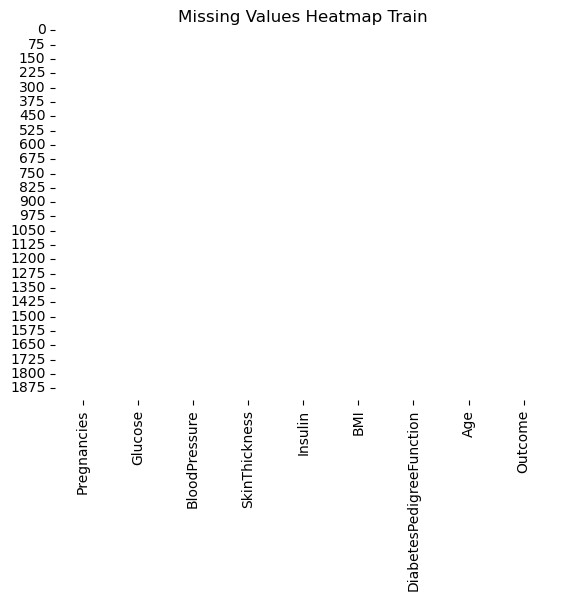

In [2]:
# Separating features -X and target -y
X = df.drop(columns="Outcome")
y = df["Outcome"]

# Column names where 0 is invalid
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replacing 0s with np.nan
for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

#wide range differences in the data set:
#	Insulin: 0 – 846
#	Glucose: 0 – 199
#	BMI: 0 – 80.6
#	DiabetesPedigreeFunction: 0.078 – 2.42
# Therfore Imputation first and then Scaling
# Need to split the database before applying imputation  and scaling
#Splitting Train and Test datasets X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42,stratify=y)



# StandardScaler(z score) and KNN Imputation is selected (for LogisticRegression Model)

imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test) # use params from X_train

scaler = StandardScaler()
X_train_imputed_scaled = scaler.fit_transform(X_train_imputed)
X_test_imputed_scaled = scaler.transform(X_test_imputed)

# just to save the preprocessed data as a csv created two datasets

X_train_imputed_scaleddf = pd.DataFrame(X_train_imputed_scaled, columns=X_train.columns)
X_test_imputed_scaleddf = pd.DataFrame(X_test_imputed_scaled, columns=X_test.columns)
y_traindf = pd.DataFrame(y_train)
y_testdf = pd.DataFrame(y_test)


X_train_preprocessed = X_train_imputed_scaleddf
X_test_preprocessed = X_test_imputed_scaleddf
# Adding back the target column
X_train_preprocessed["Outcome"] = y_traindf["Outcome"].values
X_test_preprocessed["Outcome"] = y_testdf["Outcome"].values


# Displaying first few rows
print("Training set")
print(X_train_preprocessed.head())
print("test set")
print(X_test_preprocessed.head())
# Saving to a new CSV file
X_train_preprocessed.to_csv("../../data/processed/FC212039_Healthcare-Diabetes-Preprocessed-train.csv", index=False)
X_test_preprocessed.to_csv("../../data/processed/FC212039_Healthcare-Diabetes-Preprocessed-test.csv", index=False)

sns.heatmap(X_train_preprocessed.isnull(), cbar=False, cmap='Grays')
plt.title("Missing Values Heatmap Train")
plt.show()







Accuracy score:
0.7436823104693141
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       545
           1       0.67      0.50      0.57       286

    accuracy                           0.74       831
   macro avg       0.72      0.69      0.69       831
weighted avg       0.74      0.74      0.73       831



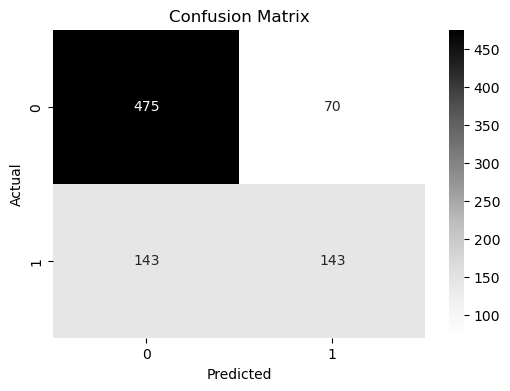

In [3]:
# fitting the model 

#y_train, y_test are Pandas DataFrames
y_train = y_train.values.ravel() 
y_test = y_test.values.ravel()   

classifier = LogisticRegression(max_iter = 1000)
classifier.fit(X_train_imputed_scaled, y_train)

y_predicted = classifier.predict(X_test_imputed_scaled)
print("Accuracy score:")
print(accuracy_score( y_test, y_predicted))
print(classification_report(y_test, y_predicted))

cm = confusion_matrix(y_test,  y_predicted)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Grays', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [8]:
#cross validation to check the accuracy 

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 1. Build the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# 2. Run cross-validation directly on the pipeline
scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')

print("Cross-validated AUC scores:", scores)
print("Mean AUC:", scores.mean())



Cross-validated AUC scores: [0.83045592 0.84242713 0.8642568  0.84574453 0.82170509]
Mean AUC: 0.8409178908635309


In [7]:
# checking if the same results come if we use a pipleline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Now use this pipeline to fit and predict:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Accuracy score:")
print(accuracy_score( y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy score:
0.7436823104693141
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       545
           1       0.67      0.50      0.57       286

    accuracy                           0.74       831
   macro avg       0.72      0.69      0.69       831
weighted avg       0.74      0.74      0.73       831

